# IMPORT LIBRARY

In [118]:
import math
import pandas_datareader as pdr
import numpy as np
import datetime as dt
import requests
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objs as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import r2_score
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError


# GET STOCK DATA 

In [ ]:
start_date = dt.datetime(2012,1,1)
end_date = dt.datetime(2022,10,26)

In [ ]:
def build_btn_dataset(start=start_date, end=end_date):
    session = requests.session()
    session.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
    index_data = pdr.get_data_yahoo("BBTN.JK", start=start_date, end=end_date, session = session)
    index_data.to_csv("BTN_STOCK.csv") 

In [ ]:
build_btn_dataset()

# LOAD DATASET

In [99]:
data = pd.read_csv('BTN_STOCK.csv')
data

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-01-02,1163.181885,1153.568848,1163.181885,1163.181885,1624870.0,961.159485
1,2012-01-03,1182.408081,1153.568848,1172.795044,1172.795044,2792031.0,969.103088
2,2012-01-04,1172.795044,1153.568848,1163.181885,1163.181885,5411900.0,961.159485
3,2012-01-05,1172.795044,1153.568848,1163.181885,1163.181885,3526447.0,961.159485
4,2012-01-06,1163.181885,1153.568848,1163.181885,1163.181885,1864128.0,961.159485
...,...,...,...,...,...,...,...
2680,2022-10-20,1535.000000,1450.000000,1460.000000,1535.000000,28234000.0,1535.000000
2681,2022-10-21,1530.000000,1500.000000,1530.000000,1500.000000,9856400.0,1500.000000
2682,2022-10-24,1545.000000,1510.000000,1510.000000,1535.000000,22476900.0,1535.000000
2683,2022-10-25,1555.000000,1520.000000,1545.000000,1525.000000,16626600.0,1525.000000


In [100]:
data.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2685 non-null   object 
 1   High       2685 non-null   float64
 2   Low        2685 non-null   float64
 3   Open       2685 non-null   float64
 4   Close      2685 non-null   float64
 5   Volume     2685 non-null   float64
 6   Adj Close  2685 non-null   float64
dtypes: float64(6), object(1)
memory usage: 147.0+ KB


In [102]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2685.000000,2685.000000,2685.000000,2685.000000,2.685000e+03,2685.000000
mean,1776.511508,1724.184964,1751.421848,1749.212706,2.980750e+07,1645.227630
std,681.032663,665.959276,674.597593,674.477173,3.886950e+07,673.834326
min,760.000000,720.000000,750.000000,745.000000,0.000000e+00,725.850708
25%,1211.247314,1180.000000,1200.000000,1200.000000,1.070850e+07,1068.375488
50%,1635.000000,1590.000000,1614.996338,1610.000000,1.959660e+07,1527.684692
75%,2170.000000,2100.000000,2150.000000,2140.000000,3.539550e+07,2087.968262
max,3890.000000,3800.000000,3840.000000,3840.000000,6.027398e+08,3643.729980


In [103]:
data_BTN = data[['Date', 'Close']].copy()
data_BTN

,Date,Close
0,2012-01-02,1163.181885
1,2012-01-03,1172.795044
2,2012-01-04,1163.181885
3,2012-01-05,1163.181885
4,2012-01-06,1163.181885
...,...,...
2680,2022-10-20,1535.000000
2681,2022-10-21,1500.000000
2682,2022-10-24,1535.000000
2683,2022-10-25,1525.000000


In [104]:
def normalize_data(df):
    scaler = MinMaxScaler()
    df['Close']=scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

data_BTN = normalize_data(data_BTN)
data_BTN.shape

(2685, 2)

# SPLITTING DATA

In [105]:
"""
1. Train : 80%
2. Test  : 10%
3. Val   : 10%
"""
Y = data_BTN['Date'].values
X = data_BTN['Close'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = False)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, shuffle = False)

In [106]:
def cekTotalData(data, nama):
  print(f"Total Data {nama}\t\t: {len(data)}")

cekTotalData(x_train, 'Train')
cekTotalData(x_test, 'Test')
cekTotalData(x_val, 'Validation')

Total Data Train		: 2148
Total Data Test		: 268
Total Data Validation		: 269


# CONVERTION DATE TO NUMERIC (NUMPY)

In [107]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [108]:
train_data = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=1000)
val_data = windowed_dataset(x_val, window_size=60, batch_size=200, shuffle_buffer=1000)

In [109]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# MODELLING

In [110]:
model = tf.keras.models.Sequential([
                                    Bidirectional(tf.keras.layers.LSTM(65, return_sequences=True)),
                                    Bidirectional(tf.keras.layers.LSTM(65, dropout=0.2)),
                                    Dense(16, activation="relu"),
                                    Dropout(0.2),
                                    Dense(8, activation="relu"),
                                    Dense(1),
])

In [111]:
min_val_MAE = (data_BTN['Close'].max() - data_BTN['Close'].min()) * 10 / 100
print(f"Minimum Nilai MAE : {min_val_MAE}")

Minimum Nilai MAE : 0.10000000000000002


In [115]:
# Membuat Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mean_absolute_error') < 0.0000000001 and logs.get('val_mean_absolute_error') < 0.0000000001):
      print("\MAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [116]:
METRICS = [
    MeanAbsoluteError(name ='mean_absolute_error'),
    MeanAbsolutePercentageError(name = 'mean_absolute_percentage_error'),
    MeanSquaredError(name = 'mean_squared_error')
]

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=METRICS)

history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[callbacks])

Epoch 1/50
11/11 [==============================] - 9s 176ms/step - loss: 0.0080 - mean_absolute_error: 0.0907 - mean_absolute_percentage_error: 238447.1562 - mean_squared_error: 0.0160 - val_loss: 4.1721e-04 - val_mean_absolute_error: 0.0228 - val_mean_absolute_percentage_error: 8.9413 - val_mean_squared_error: 8.3442e-04
Epoch 2/50
11/11 [==============================] - 1s 39ms/step - loss: 0.0074 - mean_absolute_error: 0.0879 - mean_absolute_percentage_error: 236190.1719 - mean_squared_error: 0.0147 - val_loss: 3.9728e-04 - val_mean_absolute_error: 0.0223 - val_mean_absolute_percentage_error: 8.6877 - val_mean_squared_error: 7.9455e-04
Epoch 3/50
11/11 [==============================] - 1s 34ms/step - loss: 0.0056 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 224885.3125 - mean_squared_error: 0.0112 - val_loss: 2.8758e-04 - val_mean_absolute_error: 0.0185 - val_mean_absolute_percentage_error: 7.0902 - val_mean_squared_error: 5.7515e-04
Epoch 4/50
11/11 [=========

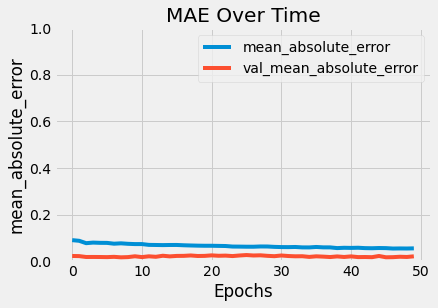

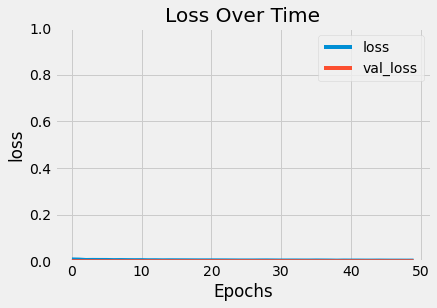

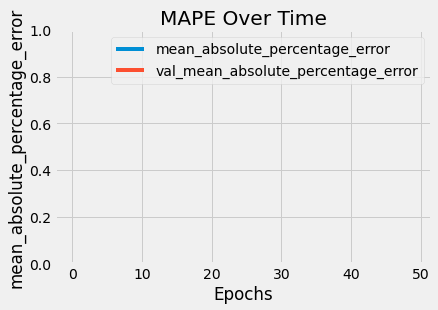

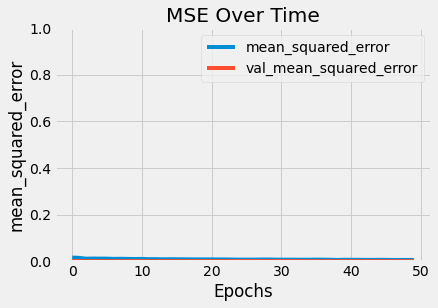

In [119]:
analisis_train = ['mean_absolute_error', 'loss', 'mean_absolute_percentage_error', 'mean_squared_error']
analisis_val = ['val_mean_absolute_error', 'val_loss', 'val_mean_absolute_percentage_error','val_mean_squared_error']
notes = ['MAE Over Time', 'Loss Over Time', 'MAPE Over Time', 'MSE Over Time']

for analize in range(0, len(analisis_train)):
  plt.plot(history.history[analisis_train[analize]], label=analisis_train[analize])
  plt.plot(history.history[analisis_val[analize]], label = analisis_val[analize])
  plt.xlabel('Epochs')
  plt.ylabel(analisis_train[analize])
  plt.ylim(0, 1)
  plt.title(notes[analize])
  plt.legend()
  plt.show()

# EVALUATE MODEL

In [120]:
test_data = windowed_dataset(x_test, window_size=60, batch_size=200, shuffle_buffer=1000)

In [122]:
eval = model.evaluate(test_data)

2/2 [==============================] - 0s 36ms/step - loss: 8.3258e-04 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 10.3151 - mean_squared_error: 0.0017


In [127]:
print(f"Hasil LOSS Evaluasi Data Test : {eval[0]}%")
print(f"Hasil MAE Evaluasi Data Test  : {eval[1]}%")
print(f"Hasil MAPE Evaluasi Data Test : {eval[2]}%")
print(f"Hasil MSE Evaluasi Data Test  : {eval[3]}%")

Hasil LOSS Evaluasi Data Test : 0.0008325833478011191%
Hasil MAE Evaluasi Data Test  : 0.031246237456798553%
Hasil MAPE Evaluasi Data Test : 10.31505298614502%
Hasil MSE Evaluasi Data Test  : 0.0016651666956022382%
